In [4]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [5]:
import numpy as np
import pandas as pd

In [6]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [7]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [8]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [9]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [10]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [11]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [39]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])


id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

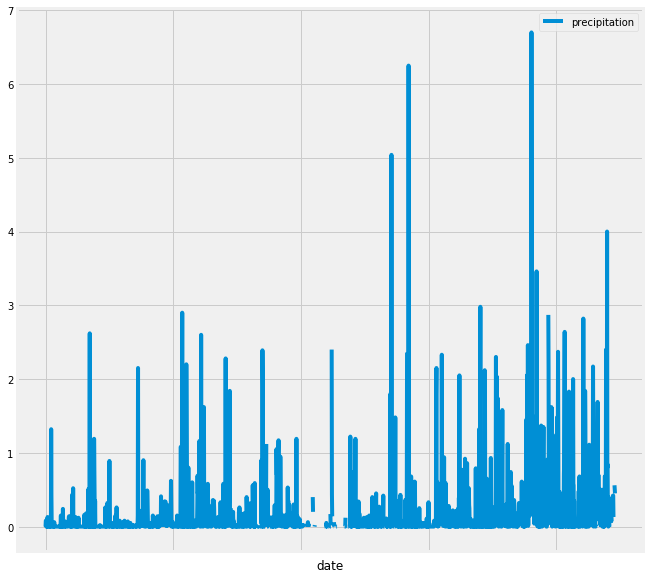

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

Latestdate = session.query(Measurement.date).order_by(Measurement.date.desc()).first() 

query_date = dt.date(2016, 8, 22) 

# - dt.timedelta(weeks=40, days=84, hours=23,minutes=50, seconds=600)

# Perform a query to retrieve the data and precipitation scores
results =session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > query_date).all()


# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['date', 'prcp'])
# df.set_index('emoji_id', inplace=True, )
df.columns = ['date','precipitation']
df.head()

# Sort the dataframe by date
precipitation = df.sort_values('date')

precipitation.head()

# Use Pandas Plotting with Matplotlib to plot the data


precipitation = df.set_index('date')
df.plot('date',x_compat=True, figsize=(10,10))
# plt.tight_layout()
plt.show()


![precipitation](Images/precipitation.png)

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [15]:
# Design a query to show how many stations are available in this dataset?

station = session.query(Station.id).count()
station


9

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station))\
.group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs))\
.filter(Measurement.station == 'USC00519281') .all()


[(54.0, 85.0, 71.66378066378067)]

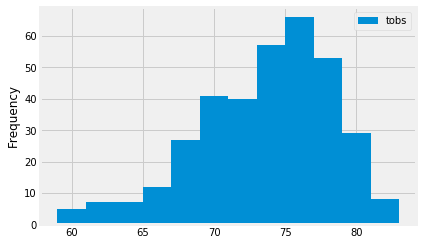

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station 
# and plot the results as a histogram
    
USC00519281_temp = session.query(Measurement.tobs).\
    filter(Measurement.date > query_date).filter(Measurement.station == 'USC00519281') .all()
USC00519281_df = pd.DataFrame(USC00519281_temp,columns=['tobs'])
USC00519281_df.plot.hist(bins=12)
plt.ylabel('Frequency')
plt.show()



![precipitation](Images/station-histogram.png)

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [27]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

startdate = query_date 
enddate = startdate - dt.timedelta(days=365)


calctemps_temp =calc_temps(enddate, startdate)
calctemps_temp

 

[(56.0, 74.43918053777209, 86.0)]

C:\Users\nag9_\Anaconda3\envs\PythonData\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


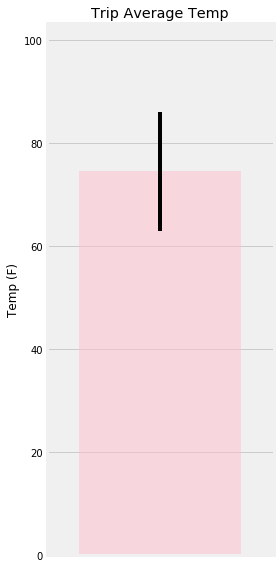

In [28]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig,ax=plt.subplots(figsize=plt.figaspect(2.))

bar=ax.bar(1,calctemps_temp[0][1],yerr=calctemps_temp[0][2] - calctemps_temp[0][1]\
           , alpha=0.5, color="pink",align="center")
ax.set(xticks=range(1),xticklabels="a",title="Trip Average Temp"\
       ,ylabel="Temp (F)")
ax.margins(.2,.2)
fig.tight_layout()
fig.show()



In [42]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

startdate = query_date - dt.timedelta(days=365)
enddate = query_date + dt.timedelta(days=365)

Rainfall_weather = [Station.station, Station.name,Station.latitude,Station.longitude,\
                    Station.elevation,func.sum(Measurement.prcp)]

Rainfall = session.query(*Rainfall_weather).filter(Measurement.station==Station.station).\
        filter(Measurement.date>=startdate).filter(Measurement.date<=enddate).\
        group_by(Station.station, Station.name,Station.latitude,Station.longitude,\
                 Station.elevation).order_by(func.sum(Measurement.prcp)).all()

print(Rainfall)

[('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.0), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 3.9499999999999997), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 9.149999999999999), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 39.890000000000036), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 76.17000000000004), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 93.49), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 120.94999999999996), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 176.8000000000002), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 324.65000000000015)]


## Optional Challenge Assignment

In [45]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-05")

[(56.0, 67.96428571428571, 76.0)]

In [50]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
Startdate = query_date 
Enddate = Startdate - dt.timedelta(days=365)
# Use the start and end date to create a range of dates
Rangedates=pd.date_range(start=Startdate, end=Enddate) 
Rangedates
# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


DatetimeIndex([], dtype='datetime64[ns]', freq='D')

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


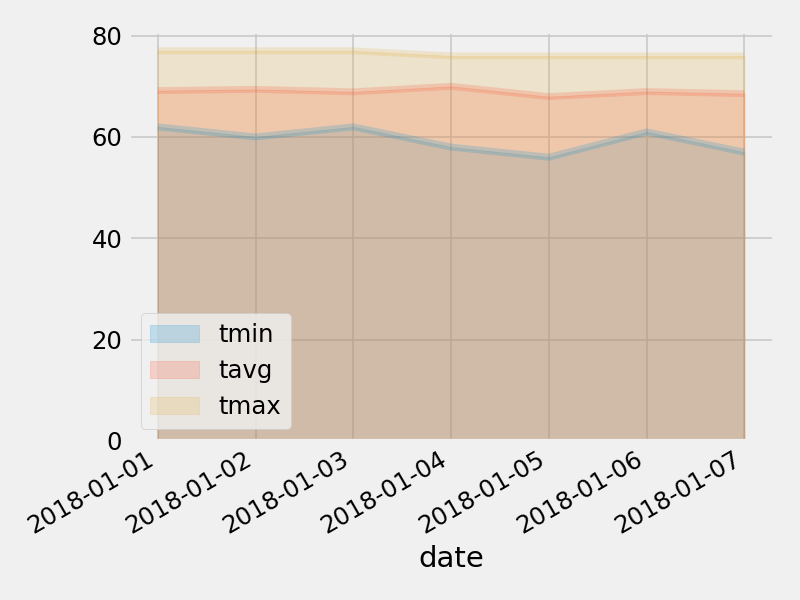

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
